# Conceptor action

In [1]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(2)

First we configure the network for a given size and connectivity.

In [2]:
# network size
N = 100

# network connectivity
netConn = 10./N

### Weight Matrix
The initial weight matrix is randomly generated and sparse:

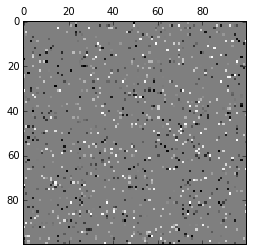

In [3]:
# initialize random weights
import scipy.sparse as sparse
W_unscaled = sparse.rand(N, N, density=netConn/2) - sparse.rand(N, N, density=netConn/2)

# sparse returns a coo-matrix, not the usual numpy matrix!

plt.matshow(W_unscaled.todense(), cmap=plt.cm.gray);

Now we scale the weight matrix such that the spectral radius (i.e. the largest eigenvalue) becomes 1. Therefore we first need to compute the spectral radius and divide by it.

In [4]:
import numpy as np
from scipy.sparse import linalg
import scipy.linalg

# compute the k=1 eigenvalues and corresponding eigenvectors with 'LM': Largest Magnitude
#specRad, largestEigenvec = np.abs(sparse.linalg.eigs(W_unscaled,k=1,which='LM'))
def getSpecRad(m):
    specRad, largestEigenvec = np.abs(scipy.linalg.eigh(m,eigvals=(N-1, N-1)))
    return specRad

specRad = getSpecRad(W_unscaled.todense())

In [5]:
W_raw = W_unscaled/specRad

# the new spectral radius is 1
getSpecRad(W_raw)

array([ 1.])

### Input Matrix
Now we set the input weights to the reservoir. It is also randomly initialized with certain scaling factors.

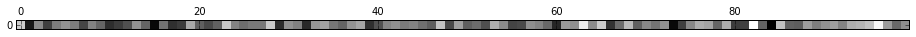

In [6]:
netInputScaling = 1.5
numInputDims = 1

W_in = netInputScaling * np.random.randn(N,numInputDims) - netInputScaling/2

plt.matshow(W_in.T, cmap=plt.cm.gray);

### Bias Matrix

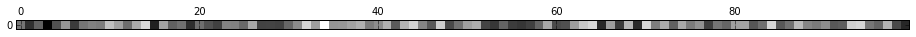

In [7]:
biasScaling = 0.2

W_bias = biasScaling * np.random.randn(N,1) - biasScaling/2

plt.matshow(np.asmatrix(W_bias.T), cmap=plt.cm.gray);

### Recap
We need these 3 matrices (weight, input, bias) for the computation of the update rule:

$ x(n+1) = \tanh (W x(n) + W_{in} p(n+1) + W_{bias} ) $

Where W is the weight matrix, currently our W_raw.

# Inputs
Now we need input patterns to train the network on.

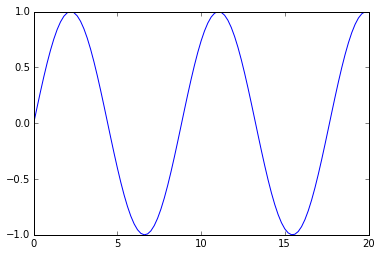

In [8]:
sinewave_1 = lambda n: np.matrix([[np.sin(2 * np.pi * n / 8.8342522)]])


x_vals = np.arange(0,20,0.2)
plt.plot(x_vals,[sinewave_1(x)[0, 0] for x in x_vals]);

# Harvesting network states

Now we let the network run and collect states from it. To get it "swinging" in the beginning, we add an additional "washout" period, during which we do not track the network.

In [9]:
washoutTimesteps = 500
learnTimesteps = 1000

# init empty state
x = np.zeros((N, 1))

stateCollector = np.zeros((N, learnTimesteps))
inputCollector = np.zeros((numInputDims, learnTimesteps))

washoutStateCollector = np.zeros((N, washoutTimesteps))

for t in xrange(washoutTimesteps + learnTimesteps):
    # get input from pattern-function
    u = sinewave_1(t)
    
    # update rule
    x = np.tanh(np.dot(W_raw, x) + np.dot(W_in, u) + W_bias)
    
    # if we are over the washout period, we start saving states
    if t >= washoutTimesteps:
        # we need to transpose x and u,
        # because accessing a row OR column in a numpy matrix always resturns a row vector
        stateCollector[:, t - washoutTimesteps] = x.T
        inputCollector[:, t - washoutTimesteps] = u.T
    
    # save washout state sequence as well for inspection
    else:
        washoutStateCollector[:, t] = x.T

### Visualize harvest

[37 35 86 32 47]


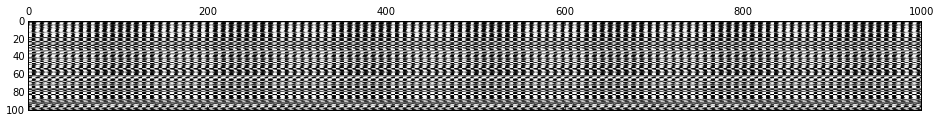

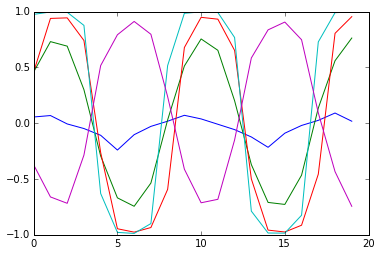

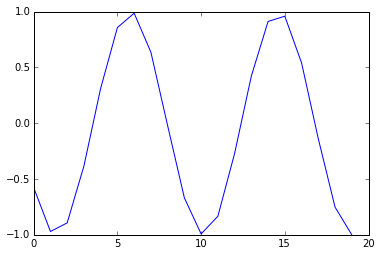

In [10]:
# show the states over time
plt.matshow(stateCollector, cmap=plt.cm.gray);

# plot 5 randomly selected neurons
plt.figure();
neuron_idxs = np.random.permutation(range(N))[0:5]
print neuron_idxs
for i in neuron_idxs:
    plt.plot(stateCollector[i ,0:20]);
    
# plot input
plt.figure();
plt.plot(inputCollector[0,0:20]);
    

### Washout inspection
What is actually happening at the beginning??

[51 70 79 74 60]


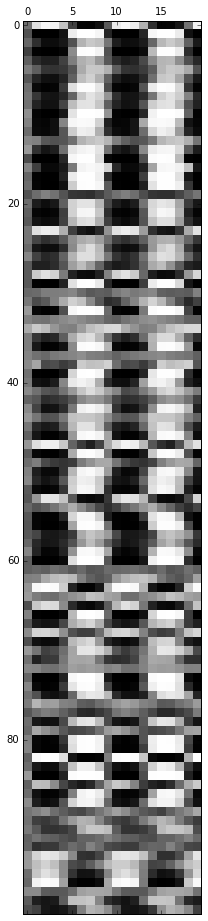

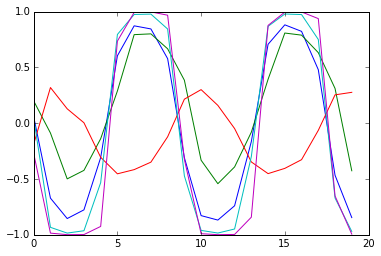

In [11]:
# show the states over time
plt.matshow(washoutStateCollector[:,0:20], cmap=plt.cm.gray);

# plot 5 randomly selected neurons
plt.figure();
neuron_idxs = np.random.permutation(range(N))[0:5]
print neuron_idxs
for i in neuron_idxs:
    plt.plot(washoutStateCollector[i ,0:20]);

It seems the network actually starts swinging almost periodically after a few timesteps or so.

## Train output weights
Train W_out such that it linearly combines the state activation to recreate the input sequence. For this we use the Tikhonov regularization (Ridge regression).

### Tikhonov regularization
The idea is to solve the equation $Ax=b$ for x under the constraint that the norm of $x$ stays small. This minimizes both the error $||Ax-b||^2$ and a regularization term $||\alpha I||^2$ where $\alpha$ is a factor of how much big weights are penalized.

So $||Ax-b||^2 + ||\alpha I||^2$ will be minimized.

An explicit solution is $\hat{x} = (A^T A + (\alpha I)^T (\alpha I))^{-1} A^T b$

In [12]:
def ridgeRegression(A, b, alpha):
    aI = alpha * np.eye(A.shape[1])
    first = np.linalg.inv(np.dot(A.T, A) + np.dot(aI.T, aI))
    return np.dot(np.dot(first, A.T), b)

Now we have to plug in our values. Since for every state we want to generate the actual input as output of the network, for every timestep it holds:

$state * W_{out} = input$

So when we calculate $W_{out}$ we want it to work for every timestep, so we solve

$stateSequence * W_{out} = inputSequence$

for $W_{out}$.

In [13]:
# we need to transpose out data to fit into the equation
W_out = ridgeRegression(
    A = stateCollector.T,
    b = inputCollector.T,
    alpha = 0.01)

## Test trained output matrix
Now we just append this phase after the washout+learning phase, such that the states that we test on are not the same we learned on.

In [14]:
testTimesteps = 200

# continue with last state
x = x

testOutputCollector = np.zeros((numInputDims, testTimesteps))
testInputCollector = np.zeros((numInputDims, testTimesteps))


for t in xrange(testTimesteps):
    # get input from pattern-function after washout and learning phase
    # this means we just continue after this phase
    u = sinewave_1(washoutTimesteps + learnTimesteps + t)
    
    # update rule
    x = np.tanh(np.dot(W_raw, x) + np.dot(W_in, u) + W_bias)
    
    # start computing outputs
    output = np.dot(x.T, W_out)
    testOutputCollector[:, t] = output.T
    testInputCollector[:, t] = u.T

### Plot output from trained output matrix vs input

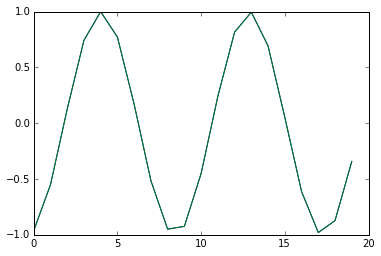

In [15]:
plt.figure()
plt.plot(testOutputCollector[0,0:20])
plt.plot(testInputCollector[0,0:20]);

### Error measure
We use the NRMSE as defined by Wikipedia:

$$NRMSE = \frac{RMSE}{y_{max}-y_{min}}$$ where $$RMSE = \sqrt{\frac{1}{n}\sum (\hat{y}-y)^2}$$

In [16]:
def NRMSE(output, target):
    error = target - output
    
    # ptp = range
    peakToPeak = np.ptp(target, axis=1)
    rmse = np.sqrt(np.mean(error**2, axis=1))
    nrmse = rmse / peakToPeak
    return nrmse

NRMSE(testOutputCollector, testInputCollector)

array([  1.58970883e-05])

# Loading
Now we load the weight matrix. This means that the weight matrix is itself capable of producing the pattern in absence of an input to the network.

Again we do a ridge regression. We want to find a new weight matrix W such that applying W to a state produces the activation that was previously produced from BOTH state- AND input-activation. So for every timestep it should hold:

$$ x(n) \cdot W_{new} = W_{old}\cdot x(n) + W_{in}\cdot u(n)$$

With the regression we fit $W_{new}$ to otimize this for all timesteps. The target for the regression is therefore

$$W_{old}\cdot x(n) + W_{in}\cdot u(n)$$

To calculate it, we rearrange the update rule:

$$ x(n+1) = \tanh (W x(n) + W_{in} p(n+1) + W_{bias} ) $$

$$W_{old}\cdot x(n) + W_{in}\cdot u(n) = \tanh^{-1} (x(n+1)) - W_{bias}$$

Now leaving away the input will still produce the same results just from letting the network run on its own.

[ 19.41219335]


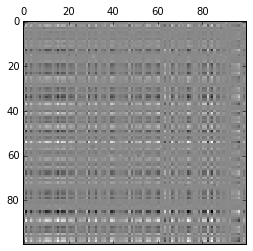

In [17]:
stateCollectorOld = np.zeros((N, learnTimesteps))
stateCollectorOld[:,1:] = stateCollector[:,0:-1]

target = np.arctanh(stateCollector) - np.tile(W_bias, (1, learnTimesteps))

W_loaded = ridgeRegression(stateCollectorOld.T, target.T, 0.0001)
plt.matshow(W_loaded, cmap=plt.cm.gray);

loadSpecRad = getSpecRad(W_loaded)
print loadSpecRad
#W_loaded = W_loaded / loadSpecRad


### Test the loading
Now when we let the network run on its own, it should produce the signal again.

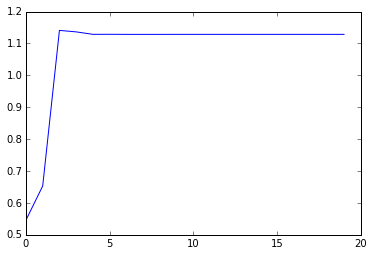

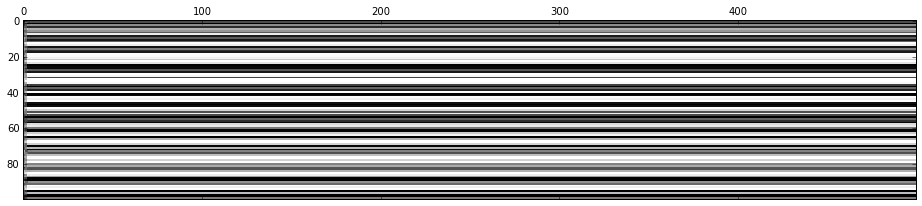

In [18]:
loadingTestTimesteps = 500

# init empty state
#x = np.zeros((N, 1))
x = 0.5*np.random.randn(N, 1)

loadingTestOutputCollector = np.zeros((numInputDims, loadingTestTimesteps))
loadingTestStateCollector = np.zeros((N, loadingTestTimesteps))

for t in xrange(loadingTestTimesteps):
    
    # update rule
    x = np.tanh(np.dot(W_loaded, x) + W_bias)
    
    loadingTestStateCollector[:, t] = x.T
    
    output = np.dot(x.T, W_out)
    loadingTestOutputCollector[:, t] = output.T
    
plt.figure()
plt.plot(loadingTestOutputCollector[0,0:20]);

plt.matshow(loadingTestStateCollector[:,:], cmap=plt.cm.gray);

# DAFUQ?